# Salary Prediction

## Task: Preprocessing

### Import packages

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
import random
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.metrics import ConfusionMatrix


### Import Dataset & Data Process
Randomly select 2500 data points from the training dataset for the ease of analysis.

Define the high salary to be the 75th percentile and above; the low salary to be below 75th
percentile.

In [2]:
df = pd.read_csv('Train_rev1.csv', low_memory=False)
#Randomly select 2500 data points from the training dataset for ease of analysis
df = df.sample(n=2500, random_state = 8)

##to detect high salary or low:
sd = df['SalaryNormalized'].quantile(0.75)

#then assign to dataframe as a dummy
df['salary'] = np.where(df['SalaryNormalized'] >= sd, 'HIGH', 'LOW')

In [3]:
##leave only useful columns
df = df[['FullDescription','salary']]

### Text data process

In [5]:
def tokenizer(words) -> list:
    #tokenizer = RegexpTokenizer(r'[\w-]+')
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
    tokens = tokenizer.tokenize(words.lower())

    stopwords_set = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    return [lemmatizer.lemmatize(token, pos='v') for token in tokens if token not in stopwords_set]

#apply tokenizer function to each post, using set to remove the repeat and store in processed column
processed_desc = []
for comment in df['FullDescription']:
    processed_desc.append(list(set(tokenizer(comment))))

##join with salary status
documents = []
for i in range(2500):
    description, salary = processed_desc[i], df.iloc[i,1]
    a = (description, salary)
    documents.append(a)
    

In [6]:
random.shuffle(documents)

In [7]:
#to join the processed_desc into a single list
processed_list = []
for i in range(len(processed_desc)):
    for j in range(len(processed_desc[i])):
        processed_list.append(processed_desc[i][j])


In [8]:
all_words = nltk.FreqDist(w.lower() for w in processed_list)

In [9]:
#constructing a list of the 2000 most frequent words in the overall corpus
word_features = list(all_words)[:2000]

In [10]:
def find_feature(listing):
    words = set(listing)
    features = {}
    for w in word_features:
        features[w] = (w in words)
    return features

In [11]:
featuresets = [(find_feature(description), salary) for (description, salary) in documents]


## Task: Build a classification model with text (full job description) as the predictor
### Use the Naïve Bayes classifier

In [12]:
#STARTING TO APPLY NAIVE BAYES CLASSIFIER
train = featuresets[:2000]
test = featuresets[2000:]
classifier = nltk.NaiveBayesClassifier.train(train)
#classifier.show_most_informative_features(15)

## Task: Calculate the model accuracy

In [13]:
print('the accuracy of the model is', nltk.classify.accuracy(classifier, test))

the accuracy of the model is 0.764


## Task: show the top 10 words (excluding stopwords) that are most indicative of (i) high salary, and (ii) low salary.

In [14]:
def show_most_informative_features_in_list(classifier, n=50):
    """
    Return a nested list of the "most informative" features 
    used by the classifier along with it's predominant labels
    """
    cpdist = classifier._feature_probdist       # probability distribution for feature values given labels
    feature_list = []
    for (fname, fval) in classifier.most_informative_features(n):
        def labelprob(l):
            return cpdist[l, fname].prob(fval)
        labels = sorted([l for l in classifier._labels if fval in cpdist[l, fname].samples()], 
                        key=labelprob)
        feature_list.append([fname, labels[-1]])
    return feature_list

In [15]:
feature_list = show_most_informative_features_in_list(classifier, 50)
n = 0
i = 0
words_high = []
while n < 10:
    if feature_list[i][-1] == 'HIGH':
        words_high.append(feature_list[i][0])
        n += 1
    i += 1
    

m = 0
j = 0
words_low = []
while m < 10:
    if feature_list[j][-1] == 'LOW':
        words_low.append(feature_list[j][0])
        m += 1
    j += 1
    

In [16]:
print('the most important 10 indicator of high salary is', words_high)
print('the most important 10 indicator of low salary is', words_low)

the most important 10 indicator of high salary is ['deliverables', 'map', 'methodology', 'cima', 'architecture', 'stakeholder', 'architect', 'pqe', 'aca', 'estimate']
the most important 10 indicator of low salary is ['hotel', 'chef', 'placement', 'pupils', 'overtime', 'assistant', 'room', 'star', 'entry', 'nights']


### Graphical Visualisation 

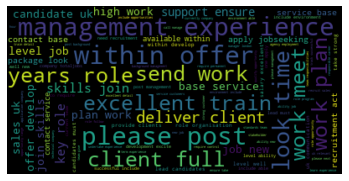

In [19]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
desc_str = ''
for i in range(len(processed_desc)):
    for j in range(len(processed_desc[i])):
        desc_str += processed_desc[i][j] + ' '
        
wordcloud_desc = WordCloud().generate(desc_str)
plt.imshow(wordcloud_desc, interpolation='bilinear')
plt.axis("off")
plt.show()

/Users/zorak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


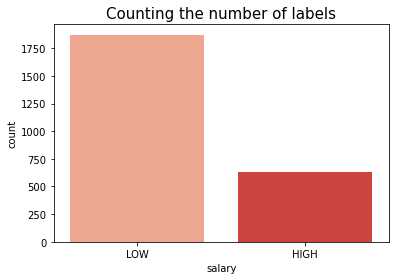

In [20]:
plt.figure(figsize=(6,4))
sns.countplot(df['salary'],palette= 'Reds')
plt.title("Counting the number of labels",fontsize=15)
plt.xticks(rotation='horizontal')
plt.show()

### Confusion Matrix

In [21]:
test_result = []
gold_result = []

for i in range(len(test)):
    test_result.append(classifier.classify(test[i][0]))
    gold_result.append(test[i][1])
CM = nltk.ConfusionMatrix(gold_result, test_result)
print(CM)

labels = {'HIGH', 'LOW'}
from collections import Counter
TP, FN, FP = Counter(), Counter(), Counter()
for i in labels:
    for j in labels:
        if i == j:
            TP[i] += int(CM[i,j])
        else:
            FN[i] += int(CM[i,j])
            FP[j] += int(CM[i,j])

print('True positive:', sum(TP.values()), TP)
print('False Negtive:', sum(FN.values()), FN)
print('False Positive:', sum(FP.values()), FP)
            
print("label\tprecision\trecall\tf_measure")
for label in sorted(labels):
    precision, recall = 0, 0
    if TP[label] == 0:
        f_measure = 0
    else:
        precision = float(TP[label]) / (TP[label]+FP[label])
        recall = float(TP[label]) / (TP[label]+FN[label])
        f_measure = float(2) * (precision * recall) / (precision + recall)
    print(label+"\t"+str(precision)+"\t"+str(recall)+"\t"+str(f_measure))

     |   H     |
     |   I   L |
     |   G   O |
     |   H   W |
-----+---------+
HIGH | <93> 37 |
 LOW |  81<289>|
-----+---------+
(row = reference; col = test)

True positive: 382 Counter({'LOW': 289, 'HIGH': 93})
False Negtive: 118 Counter({'LOW': 81, 'HIGH': 37})
False Positive: 118 Counter({'HIGH': 81, 'LOW': 37})
label	precision	recall	f_measure
HIGH	0.5344827586206896	0.7153846153846154	0.6118421052631579
LOW	0.8865030674846626	0.7810810810810811	0.8304597701149425


### Possible further steps to increase the accuracy of the model above, with the same dataset

I defined a feature extractor for documents to tell the classifier which aspect of the data it should pay attention to, but due to my limited computing power, I constructed the feature extractor with only 2000 most frequently appeared words in the descriptions. Thus, in order to increase the accuracy of the model above, I should include more frequent words in the documents for the feature extractor (such as 7000). I didn't do that because my Jupyter Notebook kept crashing when too many features were selected. 
And I trained my model with only 2500 rows of dataset, which was also very limited. To build a better model, I should try to use a larger dataset to train it.

Other solutions to improve the accuracy can be utilizing more feature engineering methods, utilizing error analysis and cross validation methods, or trying different machine learning algorithms such as support vector machines (SVM). 